In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True

sess = tf.compat.v1.Session(config=config)

import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import Audio
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras import regularizers
from tensorflow.keras import models

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

IMG_DIR = '/content/drive/MyDrive/PSV-proiect/data-set/spectrograms/' 

IMG_HEIGHT = 216
IMG_WIDTH = 216
NUM_CLASSES = 10
NUM_EPOCHS = 40
BATCH_SIZE = 32
L2_LAMBDA = 0.001

In [ ]:
all_files = os.listdir(IMG_DIR)
num_files = len(all_files)

print(len(all_files))

999


In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder

NUM_CLASSES = 10

sample_files = [ '00000_rock.jpg','00000_reggae.jpg','00000_pop.jpg', '00000_metal.jpg','00000_jazz.jpg','00000_hiphop.jpg','00000_country.jpg','00000_blues.jpg','00000_disco.jpg','00000_classical.jpg']
  
label_dict = {'rock': 0,
              'reggae': 1,
              'pop': 2,
              'metal': 3,
              'jazz': 4,
              'hiphop': 5,
              'country': 6,
              'blues': 7,
              'disco': 8,
              'classical': 9}
one_hot = OneHotEncoder(categories=[range(NUM_CLASSES)])

all_files = os.listdir(IMG_DIR)

# Get class weights
label_array = []
for file_ in all_files:
    vals = file_[:-4].split('_')
    label_array.append(label_dict[vals[1]])
    
cl_weight = compute_class_weight(class_weight = 'balanced',  
                                 classes = np.unique(label_array), 
                                 y = label_array)

# Train-val-test split of files
train_files, test_files, train_labels, test_labels = train_test_split(all_files, 
                                                                      label_array,
                                                                      random_state = 10, 
                                                                      test_size = 0.40    
                                                                     )

# Among the test files, keep half for validation
val_files, test_files, val_labels, test_labels = train_test_split(test_files, test_labels,
                                                                  random_state = 10, 
                                                                  test_size = 0.5
                                                                 )

In [ ]:
num_samples = len(all_files)
print(num_samples)

999


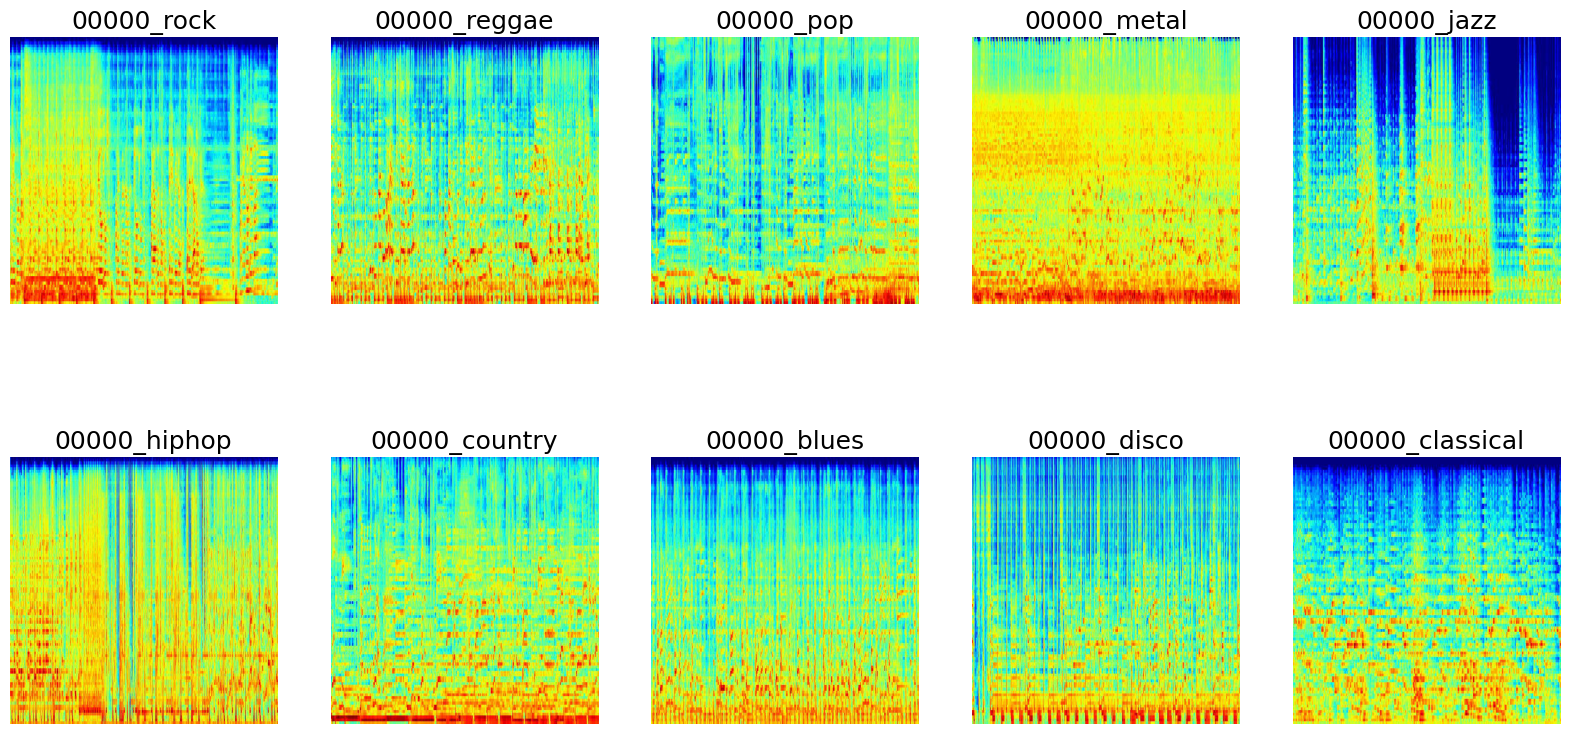

In [ ]:
f, axarr = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(20,10))
coordinates = [(0,0),(0,1),(0,2),(0,3),(0,4),
               (1,0),(1,1),(1,2),(1,3),(1,4) ]

for i, file_ in enumerate(sample_files):
    im = Image.open(IMG_DIR + file_)
    axarr[coordinates[i]].imshow(np.asarray(im))
    axarr[coordinates[i]].axis('off')
    axarr[coordinates[i]].set_title(file_[:-4], fontsize=18)

Samples above show that the spectrograms are different for different genres.

In [ ]:
conv_base = tf.keras.applications.VGG16(include_top = False, 
                                            weights = 'imagenet', 
                                            input_shape = (IMG_WIDTH, IMG_HEIGHT, 3) # 3 channels - RGB
                                           ) 
# The weights are for the CONV filters - hence you can pass any pre-set image size to this VGG network
# Need not be 224 x 224 x 3 (Although does it work better for 224 size? Need to check)

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 216, 216, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 216, 216, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 216, 216, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 108, 108, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 108, 108, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 108, 108, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 54, 54, 128)       0     

In [ ]:
model = models.Sequential() 
model.add(conv_base)#a
model.add(layers.Flatten()) 

# 1-layer MLP with Dropout, BN 
model.add(layers.Dense(512, name='dense_1', kernel_regularizer=regularizers.l2(L2_LAMBDA)))
model.add(layers.Dropout(rate=0.3, name='dropout_1')) 
model.add(layers.Activation(activation='relu', name='activation_1'))

model.addlayers.Dense(NUM_CLASSES, activation='softmax', name='dense_output')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense_1 (Dense)             (None, 512)               9437696   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dense_output (Dense)        (None, 10)                5130      
                                                                 
Total params: 24,157,514
Trainable params: 24,157,514
No

In [ ]:
# Set the convolution base to be not trainable
conv_base.trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense_1 (Dense)             (None, 512)               9437696   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dense_output (Dense)        (None, 10)                5130      
                                                                 
Total params: 24,157,514
Trainable params: 9,442,826
Non

In [ ]:
def load_batch(file_list): 
    idx_array = []
    label_array = []

    for file_ in file_list:
        im = Image.open(IMG_DIR + file_)
        im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
        img_array.append(np.array(im))

        vals = file_[:-4].split('_')
        idx_array.append(vals[0])
        label_array.append([label_dict[vals[1]]])

    label_array = one_hot.fit_transform(label_array).toarray()
    img_array = np.array(img_array)/255.0 # Normalize RGB
    
    return img_array, np.array(label_array), np.array(idx_array)

In [ ]:
def batch_generator(files, BATCH_SIZE): 
    L = len(files)

    # this line is just to make the generator infinite, keras needs that    
    while True:

        batch_start = 0
        batch_end = BATCH_SIZE

        while batch_start < L:
            
            limit = min(batch_end, L)
            file_list = files[batch_start:limit]
            batch_img_array, batch_label_array, batch_idx_array = load_batch(file_list)

            yield (batch_img_array, batch_label_array) # a tuple with two numpy arrays with batch_size samples     

            batch_start += BATCH_SIZE   
            batch_end += BATCH_SIZE



In [ ]:
# Set optimizer, loss and metrics
optimizer = optimizers.Adam(learning_rate=1e-5) 
loss = 'categorical_crossentropy' 
metrics = ['categorical_accuracy']

filepath = "/content/drive/MyDrive/PS-proiect/saved_models/transfer_learning_epoch_{epoch:02d}_{val_categorical_accuracy:.4f}.h5"
checkpoint = callbacks.ModelCheckpoint(filepath, 
                                       monitor='val_categorical_accuracy', 
                                       verbose=0, 
                                       save_best_only=False)
callbacks_list = [checkpoint]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
print(len(train_files))

599


In [ ]:
print(len(val_files))


200


STEPS_PER_EPOCH = len(train_files)//BATCH_SIZE
VAL_STEPS = len(val_files)//BATCH_SIZE

history = model.fit(batch_generator(train_files, BATCH_SIZE),
                              epochs     = NUM_EPOCHS,
                              steps_per_epoch = STEPS_PER_EPOCH,
                              class_weight = cl_weight, # Check if providing class weight is useful
                              validation_data = batch_generator(val_files, BATCH_SIZE), 
                              validation_steps = VAL_STEPS, 
                              callbacks = callbacks_list,
                             )

In [ ]:
print(label_dict)


{'rock': 0, 'reggae': 1, 'pop': 2, 'metal': 3, 'jazz': 4, 'hiphop': 5, 'country': 6, 'blues': 7, 'disco': 8, 'classical': 9}


In [ ]:
print(train_files)
print(val_files)

['00027_reggae.jpg', '00035_blues.jpg', '00094_classical.jpg', '00011_jazz.jpg', '00069_metal.jpg', '00088_rock.jpg', '00062_country.jpg', '00073_pop.jpg', '00029_disco.jpg', '00028_pop.jpg', '00004_blues.jpg', '00011_metal.jpg', '00006_country.jpg', '00012_hiphop.jpg', '00055_reggae.jpg', '00074_hiphop.jpg', '00088_hiphop.jpg', '00013_hiphop.jpg', '00074_jazz.jpg', '00002_jazz.jpg', '00005_reggae.jpg', '00029_classical.jpg', '00023_rock.jpg', '00070_reggae.jpg', '00003_hiphop.jpg', '00018_classical.jpg', '00023_disco.jpg', '00015_disco.jpg', '00083_rock.jpg', '00043_country.jpg', '00010_pop.jpg', '00028_blues.jpg', '00054_blues.jpg', '00040_country.jpg', '00011_reggae.jpg', '00011_rock.jpg', '00005_disco.jpg', '00056_hiphop.jpg', '00063_classical.jpg', '00096_rock.jpg', '00030_hiphop.jpg', '00031_pop.jpg', '00050_jazz.jpg', '00074_classical.jpg', '00060_pop.jpg', '00023_reggae.jpg', '00084_blues.jpg', '00077_hiphop.jpg', '00017_classical.jpg', '00031_metal.jpg', '00008_hiphop.jpg', '0

In [ ]:
STEPS_PER_EPOCH = len(train_files)//BATCH_SIZE
VAL_STEPS = len(val_files)//BATCH_SIZE

print(STEPS_PER_EPOCH)
print(VAL_STEPS)
cl_weight = dict(enumerate(cl_weight))

history = model.fit(batch_generator(train_files, BATCH_SIZE),
                    epochs=NUM_EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=batch_generator(val_files, BATCH_SIZE),
                    validation_steps=VAL_STEPS,
                    class_weight=cl_weight,
                    callbacks = callbacks_list)

18
6
Epoch 1/40
18/18 [==============================] - 502s 28s/step - loss: 3.4181 - categorical_accuracy: 0.1285 - val_loss: 3.2195 - val_categorical_accuracy: 0.1771
Epoch 2/40
18/18 [==============================] - 465s 26s/step - loss: 3.2120 - categorical_accuracy: 0.1940 - val_loss: 3.1228 - val_categorical_accuracy: 0.2969
Epoch 3/40
18/18 [==============================] - 495s 28s/step - loss: 3.0645 - categorical_accuracy: 0.2416 - val_loss: 3.0026 - val_categorical_accuracy: 0.3490
Epoch 4/40
18/18 [==============================] - 502s 28s/step - loss: 2.9378 - categorical_accuracy: 0.3175 - val_loss: 2.9074 - val_categorical_accuracy: 0.3854
Epoch 5/40
18/18 [==============================] - 497s 28s/step - loss: 2.8323 - categorical_accuracy: 0.3386 - val_loss: 2.8305 - val_categorical_accuracy: 0.4062
Epoch 6/40
18/18 [==============================] - 490s 28s/step - loss: 2.7357 - categorical_accuracy: 0.3933 - val_loss: 2.7542 - val_categorical_accuracy: 0.4479

In [ ]:
# Save scores on train and validation sets
with open('/content/drive/MyDrive/PSV-proiect/pickle_files/transfer_learning_vgg16_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

#### Determine the best performing model

In [ ]:
# Load scores
import pandas as pd
import pickle
with open('/content/drive/MyDrive/PSV-proiect/pickle_files/transfer_learning_vgg16_history.pkl', 'rb') as f:
    scores = pickle.load(f)
print(scores.keys())
print(scores)
scores = pd.DataFrame(scores, index=range(1,41))

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])
{'loss': [3.4181296825408936, 3.211986780166626, 3.0644829273223877, 2.9377646446228027, 2.8323323726654053, 2.7357051372528076, 2.640611410140991, 2.542686939239502, 2.4616479873657227, 2.4200401306152344, 2.363502264022827, 2.3107712268829346, 2.2483856678009033, 2.1579535007476807, 2.111509084701538, 2.072662353515625, 2.0105223655700684, 1.9815446138381958, 1.9297105073928833, 1.917309284210205, 1.8615666627883911, 1.8423622846603394, 1.7925474643707275, 1.77909517288208, 1.7393704652786255, 1.7099392414093018, 1.6613069772720337, 1.6220319271087646, 1.621204137802124, 1.5849525928497314, 1.5728310346603394, 1.538331151008606, 1.493577480316162, 1.4698619842529297, 1.481314778327942, 1.4350024461746216, 1.4193646907806396, 1.414535403251648, 1.3768924474716187, 1.3616615533828735], 'categorical_accuracy': [0.1284722238779068, 0.19400352239608765, 0.24162258207798004, 0.3174603283405304, 0.3386243283

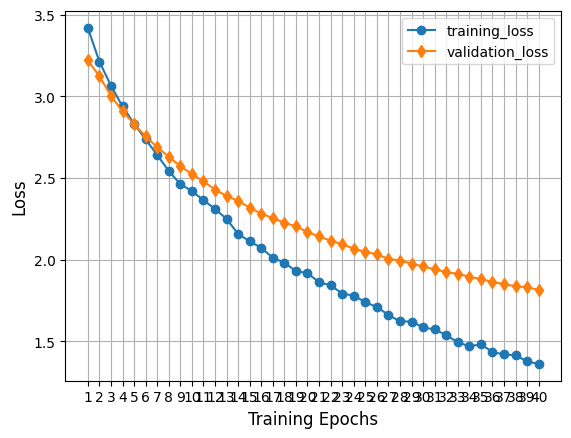

In [ ]:
plt.xticks(range(1,41))
plt.plot(scores['loss'], marker='o', label='training_loss')
plt.plot(scores['val_loss'], marker='d', label='validation_loss')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Training Epochs', fontsize=12)
plt.grid()
plt.legend()

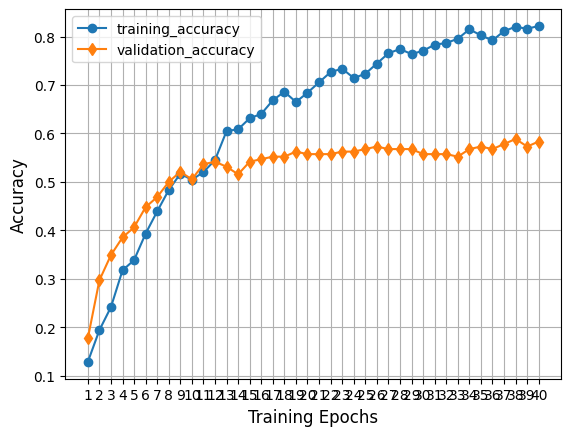

In [ ]:
plt.xticks(range(1,41))
plt.plot(scores['categorical_accuracy'], marker='o', label='training_accuracy')
plt.plot(scores['val_categorical_accuracy'], marker='d', label='validation_accuracy')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Training Epochs', fontsize=12)
plt.grid()
plt.legend()

Alegem epoca 37 pentru acuratete maxima


In [37]:
model = models.load_model(filepath='/content/drive/MyDrive/PSV-proiect/saved_models/transfer_learning_epoch_37_0.5938.h5') # 37

In [38]:
# Make Prediction on Test set
TEST_STEPS = len(test_files)//BATCH_SIZE
pred_probs = model.predict_generator(generator = batch_generator(test_files, BATCH_SIZE), 
                                     steps=TEST_STEPS)
pred = np.argmax(pred_probs, axis=-1)
print(pred)



<ipython-input-38-e8c16391254f>:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred_probs = model.predict_generator(generator = batch_generator(test_files, BATCH_SIZE),


[6 2 6 0 6 0 0 3 8 3 5 7 3 4 3 0 7 3 3 7 9 2 5 3 7 7 1 4 3 0 1 8 3 4 6 7 6
 1 6 2 6 0 4 4 9 1 1 9 1 9 9 9 9 9 1 0 8 0 6 1 2 0 1 1 2 2 3 9 4 5 1 4 0 1
 2 1 9 0 7 4 0 8 0 9 2 6 1 0 2 9 5 1 6 6 3 5 5 2 2 8 1 4 9 4 0 5 7 0 3 9 3
 7 5 8 6 1 1 2 0 8 5 3 1 6 9 7 0 1 6 3 3 2 1 6 5 2 5 2 2 7 3 9 4 5 2 5 5 1
 8 6 0 1 4 7 6 1 5 7 8 6 5 6 8 0 5 8 4 2 4 0 0 8 3 5 4 3 0 6 2 7 4 1 5 7 3
 6 3 6 6 9 2 7]


In [39]:
with open('/content/drive/MyDrive/PSV-proiect/pred_probas/testset_filenames.txt', 'w') as f:
    f.write('\n'.join([t.split('.')[0]+'.wav' for t in test_files]))

In [40]:
with open('/content/drive/MyDrive/PSV-proiect/pred_probas/vgg_transfer_learning.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

### Evaluation of the best performing model

In [41]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc, classification_report
from scipy import interp
import itertools
from itertools import cycle
def plot_confusion_matrix(cm, classes,  #matricea de confuzie
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):     
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

Confusion matrix, without normalization
[[14  4  2  0  0  1  2  1  1  0]
 [ 1 11  2  0  0  2  2  0  0  0]
 [ 0  1 14  0  1  1  1  0  0  0]
 [ 1  0  0 19  0  0  0  0  0  0]
 [ 0  2  0  0 14  0  1  0  0  2]
 [ 0  1  0  1  0 12  0  0  1  0]
 [ 3  0  2  1  1  0 14  1  0  0]
 [ 3  5  0  0  0  1  1 14  0  0]
 [ 1  1  0  0  0  2  2  0 10  1]
 [ 0  0  0  0  0  0  0  0  0 14]]


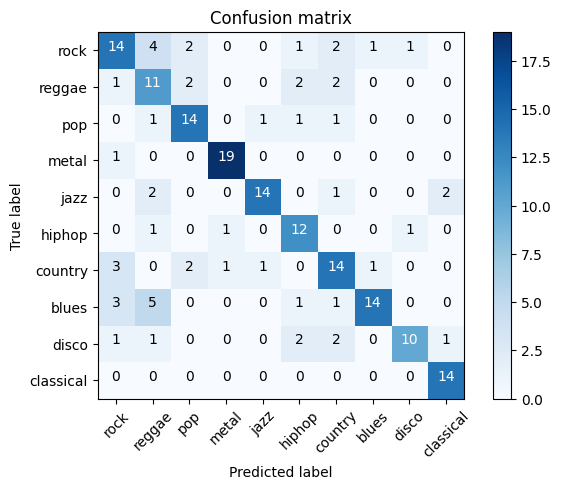

In [42]:
plot_confusion_matrix(confusion_matrix(y_true=test_labels[:len(pred)], y_pred=pred), 
                      classes=label_dict.keys())

In [43]:
print('Test Set Accuracy =  {0:.2f}'.format(accuracy_score(y_true=test_labels[:len(pred)], y_pred=pred)))
print('Test Set F-score =  {0:.2f}'.format(f1_score(y_true=test_labels[:len(pred)], y_pred=pred, average='macro')))

Test Set Accuracy =  0.71
Test Set F-score =  0.72


In [44]:
one_hot_true = one_hot_encoder(test_labels, len(pred), len(label_dict))
print('ROC AUC = {0:.3f}'.format(roc_auc_score(y_true=one_hot_true, y_score=pred_probs, average='macro')))

ROC AUC = 0.945


<ipython-input-45-2ea977923845>:16: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


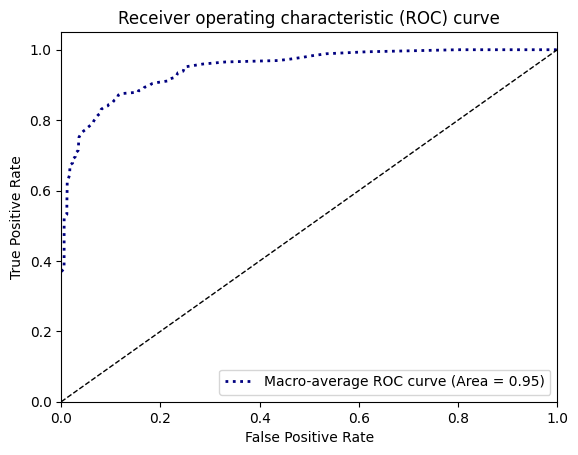

In [45]:
# Compute macro-average ROC curve and ROC area
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(one_hot_true[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])    

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(NUM_CLASSES):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= NUM_CLASSES

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (Area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

In [46]:
true_labels = test_labels[:len(pred)]
predicted_labels = pred

# Generate the classification report
report = classification_report(true_labels, predicted_labels)

# Print the report
print(report)

              precision    recall  f1-score   support

           0       0.61      0.56      0.58        25
           1       0.44      0.61      0.51        18
           2       0.70      0.78      0.74        18
           3       0.90      0.95      0.93        20
           4       0.88      0.74      0.80        19
           5       0.63      0.80      0.71        15
           6       0.61      0.64      0.62        22
           7       0.88      0.58      0.70        24
           8       0.83      0.59      0.69        17
           9       0.82      1.00      0.90        14

    accuracy                           0.71       192
   macro avg       0.73      0.72      0.72       192
weighted avg       0.73      0.71      0.71       192

